# Introduction

For this exercise, you have been provided with HyMap data from the Injune study site in Queensland, Australia (Lucas et al., 2008), an example of which has been given below:

![Example HyMap Image](figures/hymap_example.png)

The HyMap sensor measures 126 wavelengths from the blue to SWIR. Visualising hyperspectral data can be tricky in that you need to select just 3 bands, it is often best to look at the spectral curves of features you are interested in and then select bands where there is strong discrimination between the surfaces you are interested in. At the Injune site, we are primarily interested in the forest types and therefore a bands combination of NIR (band 42; 1050nm), Red-Edge (band 19; 716nm) and Blue (band 1; 446nm) is a good choice (see Figure above). 


# 1. Import Modules

In [1]:
import os
import shutil

import tqdm

import numpy

import rsgislib.imagecalc
import rsgislib.imageutils
import rsgislib.rastergis
import rsgislib.tools.utils

# Import some extra functions for compatability with
# older versions of rsgislib.
from extra_funcs import *

# Imports for data visualisation
import rsgislib.tools.plotting

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# 2. Define Input Datasets

In [2]:
input_ref_img = "../data/hymap_injune_subset.kea"
hymap_meta_file = "../data/hymap_wavelengths.json"

# 3. Create Copy of Input Image and Output Directory

As we will be editting the input image head info, we will first create a copy of this image so we do not overwrite the original input image. 


In [3]:
input_img = "hymap_injune_subset.kea"
shutil.copy(input_ref_img, input_img)

out_dir = "hymap_out_dir"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)


# 4. Visualise Input Image

Image Data Size: 628 x 2702


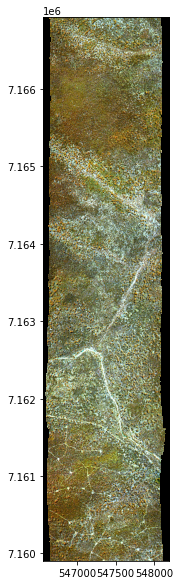

In [4]:
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[32, 19, 1]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data_strch, extent=img_coords)


# 5. Adding Wavelengths to the image meta-data

It is often useful to have the wavelengths of the bands in the image metadata when processing hyperspectral data. To set the wavelengths we need to know what the wavelengths are. This is given in ‘hymap_wavelengths.json’ file which when read into Python will be represented as a dict data structure. 

Within the GDAL data model, image data allow metadata to be added to both the image and individual image bands. We will add the wavelength and the full width half maximum (FWHM) of that wavelength to each image band. Using the wavelength and the FWHM we can represent a simplified sensor response function as a gaussian.


In [5]:
hymap_metadata = rsgislib.tools.utils.read_json_to_dict(hymap_meta_file)

# Get the number of image bands in the input image.
n_bands = rsgislib.imageutils.get_img_band_count(input_img)

# Iterate the through the image bands to define the wavelength/fwhm
# Note, image band numbers start at 1 while array indexing starts at 0.
for n in tqdm.tqdm(range(n_bands)):
    rsgislib.imageutils.set_img_band_metadata(input_img, n+1, 'wavelength', "{}".format(hymap_metadata['wavelength'][n]))
    rsgislib.imageutils.set_img_band_metadata(input_img, n+1, 'wavelength_units', "Nanometers")
    rsgislib.imageutils.set_img_band_metadata(input_img, n+1, 'fwhm', "{}".format(hymap_metadata['fwhm'][n]))


100%|███████████████████████████████████████████████████████████████████████████████████████████| 126/126 [02:44<00:00,  1.30s/it]


You can view this metadata using the gdal_info command line tool, as shown below. Note, given there are 126 bands the output will be long and therefore it is recommended that you "Enable Scrolling for Outputs" by right-clicking on the left hand side of the notebook margin. 

In [6]:
# the '!' indicates that this is a command line tool to be run on the terminal.
!gdalinfo -norat hymap_injune_subset.kea

Driver: KEA/KEA Image Format (.kea)
Files: hymap_injune_subset.kea
Size is 628, 2702
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 55S",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",147,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["Meter",1],
            ID["EPSG",8806]],
    

# 6. Setting Image Band Names

Often, within the GIS software we are using to visualise the data the band are simply names based on their band number. You can also set the band name or description to a user defined piece of text. This can be useful when there are large number of bands and you want to know which one is which. 


In [7]:
# Iterate through bands to create band names which is the
# wavelength and unit (e.g., 000nm).
band_names = []
for n in range(n_bands):
    band_names.append('{}nm'.format(int(hymap_metadata['wavelength'][n])))

# Write the band names to the image.
rsgislib.imageutils.set_band_names(input_img, band_names)

You can see the band description using the gdalinfo command and if you now open it in TuiView you will see the band names have changed. When running gdal_info the band name is within the "Description" meta-data.

In [8]:
# the '!' indicates that this is a command line tool to be run on the terminal.
!gdalinfo -norat hymap_injune_subset.kea

Driver: KEA/KEA Image Format (.kea)
Files: hymap_injune_subset.kea
Size is 628, 2702
Coordinate System is:
PROJCRS["unnamed",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 55S",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",147,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["Meter",1],
            ID["EPSG",8806]],
    

# 7. Manual Band Subset

It can often be useful to subset the bands to just those we want to use for visualisation. This can make the visualisation faster and easier with smaller file sizes. 

You can use the code below to subset the data to the bands we are using for visualisation: NIR (band 42; 1050nm), Red-Edge (band 19; 716nm) and Blue (band 1; 446nm)

In this case, the GeoTIFF as the format will be used for the output image. This can be useful for opening in QGIS and other software. However, by default GeoTIFF does not use compression, however this can be turned on in RSGISLib as shown below.

In [9]:
# Set the GTIFF output options to use LZW compression.
rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

# Define the output image
output_img = os.path.join(out_dir, 'hymap_injune_subset_b42b19b1.tif')

# bands to be selected and the order they will be outputted
bands = [42,19,1]
rsgislib.imageutils.select_img_bands(input_img, output_img, 'GTIFF', rsgislib.TYPE_16INT, bands)

# Calculate image pyramids and statistics
rsgislib.imageutils.pop_img_stats(output_img, use_no_data=True, no_data_val=0, calc_pyramids=True)


New image width = 628 height = 2702 bands = 3



Calculating Image Pyramids.




# 8. Create Valid Mask

In [10]:
vld_msk_img = os.path.join(out_dir, 'hymap_injune_subset_vld_msk.kea')

rsgislib.imageutils.gen_valid_mask(input_img, output_img=vld_msk_img, gdalformat="KEA", no_data_val=0.0)

# Populate with stats and pyramids as it is a thematic image then use rastergis function.
rsgislib.rastergis.pop_rat_img_stats(clumps_img=vld_msk_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True)

0) hymap_injune_subset.kea
New image width = 628 height = 2702 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


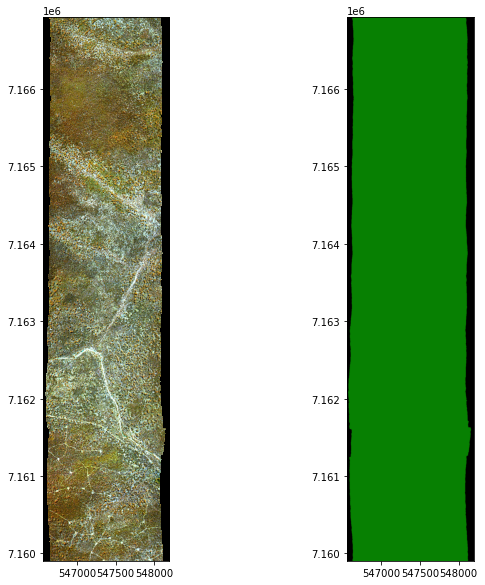

In [11]:
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[32, 19, 1]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(vld_msk_img)

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_msk_data, extent=img_msk_coords)

# 9. Spectral Smoothing

A common analysis which is applied to hyperspectral data is spectral smoothing. A common approach is Savitzky-Golay filtering which locally fits a polynomial within a sliding window along the spectra. Parameters for Savitzky-Golay filter are therefore the size of the window and the order of the polynomial function. Increasing the window size will produce a smoother output but will also remove more features from the spectra.

In [12]:
spec_smooth_img = os.path.join(out_dir, 'hymap_injune_subset_smoothed.kea')

rsgislib.imageutils.spectral_smoothing(input_img, valid_msk_img=vld_msk_img, valid_msk_val=1, output_img=spec_smooth_img, win_len = 5, polyorder = 3, gdalformat = 'KEA', datatype=rsgislib.TYPE_16INT, calc_stats = True)

  0%|          | 0/100 [00:00<?, ?it/s]



Calculating Image Pyramids.
































































































































# 9.1 Visualise Spectra

*Note, the function used to extract the image pixels values is suboptimal as the function is intended to sample a number of pixel values from a single band rather than be used to extract a single pixel value from a large number of bands. A more efficient function should be implemented for this in the future.*

In [13]:
# Get image pixel values for pixel 50, 100
orig_pxl_vals = get_img_pxl_column(input_img, x_pxl_coord=50, y_pxl_coord=100)
smth_pxl_vals = get_img_pxl_column(spec_smooth_img, x_pxl_coord=50, y_pxl_coord=100)

Text(0.5, 0, 'Wavelength (nm)')

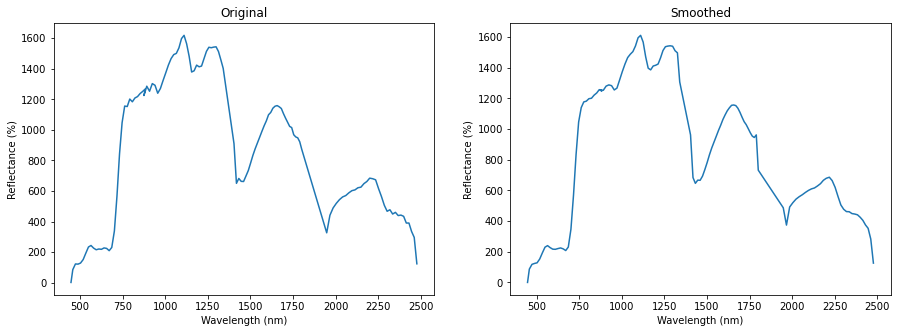

In [14]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(hymap_metadata['wavelength'], orig_pxl_vals, label="Original")
ax1.set_title("Original")
ax1.set_ylabel('Reflectance (%)')
ax1.set_xlabel('Wavelength (nm)')

ax2.plot(hymap_metadata['wavelength'], smth_pxl_vals, label="Smoothed")
ax2.set_title("Smoothed")
ax2.set_ylabel('Reflectance (%)')
ax2.set_xlabel('Wavelength (nm)')

# 10. Dimensionality Reduction

Will so many image bands which are close in wavelength and therefore highly correlated to one another it is often desirable to perform a dimensionality reduction, such as principal component analysis to reduce the number of bands to make visualisation easier and in some cases simplifying and speeding up further data analysis (e.g., image segmentation, classification)

# 10.1 Principle Component Analysis (PCA)

PCA is the most common dimensionality reduction method so let’s try that first:

In [15]:
pca_img = os.path.join(out_dir, 'hymap_injune_subset_pca.kea')
out_eigen_vec_file = os.path.join(out_dir, 'hymap_injune_subset_pca_.kea')

rsgislib.imagecalc.perform_image_pca(input_img, pca_img, out_eigen_vec_file, n_comps=None, pxl_n_sample=100, gdalformat='KEA', datatype=rsgislib.TYPE_32UINT, no_data_val=0, calc_stats=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 20.75it/s]


15396 values were extracted from the input image.
Prop. of variance explained:
	 PCA Component 1 = 0.8622
	 PCA Component 2 = 0.1184
	 PCA Component 3 = 0.0083
	 PCA Component 4 = 0.0054
	 PCA Component 5 = 0.0028
	 PCA Component 6 = 0.0008
	 PCA Component 7 = 0.0006
	 PCA Component 8 = 0.0003
	 PCA Component 9 = 0.0002
	 PCA Component 10 = 0.0002
	 PCA Component 11 = 0.0001
	 PCA Component 12 = 0.0001
	 PCA Component 13 = 0.0001
	 PCA Component 14 = 0.0001
	 PCA Component 15 = 0.0001
	 PCA Component 16 = 0.0
	 PCA Component 17 = 0.0
	 PCA Component 18 = 0.0
	 PCA Component 19 = 0.0
	 PCA Component 20 = 0.0
	 PCA Component 21 = 0.0
	 PCA Component 22 = 0.0
	 PCA Component 23 = 0.0
	 PCA Component 24 = 0.0
	 PCA Component 25 = 0.0
	 PCA Component 26 = 0.0
	 PCA Component 27 = 0.0
	 PCA Component 28 = 0.0
	 PCA Component 29 = 0.0
	 PCA Component 30 = 0.0
	 PCA Component 31 = 0.0
	 PCA Component 32 = 0.0
	 PCA Component 33 = 0.0
	 PCA Component 34 = 0.0
	 PCA Component 35 = 0.0
	 PCA Comp

array([8.62218122e-01, 1.18386412e-01, 8.29299953e-03, 5.43606227e-03,
       2.83618036e-03, 7.89681886e-04, 5.62938995e-04, 2.79457175e-04,
       2.14731835e-04, 1.68507425e-04, 1.12430596e-04, 8.33769818e-05,
       8.07290262e-05, 5.86563635e-05, 5.42628080e-05, 4.76125985e-05,
       3.49117563e-05, 3.37086079e-05, 2.62047080e-05, 2.24828678e-05,
       1.88760103e-05, 1.66049173e-05, 1.43043967e-05, 1.41424571e-05,
       1.34670350e-05, 1.21035928e-05, 1.00235818e-05, 9.32760781e-06,
       8.63614416e-06, 7.50161305e-06, 6.93729155e-06, 6.12168873e-06,
       5.77369638e-06, 5.43476235e-06, 5.02433442e-06, 4.82487313e-06,
       4.58179382e-06, 4.00799093e-06, 3.81449292e-06, 3.55231965e-06,
       3.30973288e-06, 3.18342038e-06, 3.11980830e-06, 2.84956726e-06,
       2.74154796e-06, 2.54827067e-06, 2.48792825e-06, 2.25173373e-06,
       2.06773697e-06, 2.05047605e-06, 1.96816238e-06, 1.87676952e-06,
       1.84098813e-06, 1.72268827e-06, 1.66928549e-06, 1.64190315e-06,
      

Reading in from file hymap_out_dir/hymap_injune_subset_pca_.kea
Finished reading in matrix
Reading in image hymap_injune_subset.kea
New image width = 628 height = 2702 bands = 126



Calculating Image Pyramids.
































































































































In the outputs you will see the amount of variance described by each principal component, from which you can see that 86% is described by the first PC, 12% by the second PC with 0.8% by the third PC. *Note. your values might differ slightly*

We could therefore output a PCA image with just the first 5 principle components:


In [16]:
pca_img = os.path.join(out_dir, 'hymap_injune_subset_pca.kea')
out_eigen_vec_file = os.path.join(out_dir, 'hymap_injune_subset_pca_.kea')

rsgislib.imagecalc.perform_image_pca(input_img, pca_img, out_eigen_vec_file, n_comps=5, pxl_n_sample=100, gdalformat='KEA', datatype=rsgislib.TYPE_32UINT, no_data_val=0, calc_stats=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 17.33it/s]


15396 values were extracted from the input image.
Prop. of variance explained:
	 PCA Component 1 = 0.8622
	 PCA Component 2 = 0.1184
	 PCA Component 3 = 0.0083
	 PCA Component 4 = 0.0054
	 PCA Component 5 = 0.0028
	 PCA Component 6 = 0.0008
	 PCA Component 7 = 0.0006
	 PCA Component 8 = 0.0003
	 PCA Component 9 = 0.0002
	 PCA Component 10 = 0.0002
	 PCA Component 11 = 0.0001
	 PCA Component 12 = 0.0001
	 PCA Component 13 = 0.0001
	 PCA Component 14 = 0.0001
	 PCA Component 15 = 0.0001
	 PCA Component 16 = 0.0
	 PCA Component 17 = 0.0
	 PCA Component 18 = 0.0
	 PCA Component 19 = 0.0
	 PCA Component 20 = 0.0
	 PCA Component 21 = 0.0
	 PCA Component 22 = 0.0
	 PCA Component 23 = 0.0
	 PCA Component 24 = 0.0
	 PCA Component 25 = 0.0
	 PCA Component 26 = 0.0
	 PCA Component 27 = 0.0
	 PCA Component 28 = 0.0
	 PCA Component 29 = 0.0
	 PCA Component 30 = 0.0
	 PCA Component 31 = 0.0
	 PCA Component 32 = 0.0
	 PCA Component 33 = 0.0
	 PCA Component 34 = 0.0
	 PCA Component 35 = 0.0
	 PCA Comp

array([8.62218122e-01, 1.18386412e-01, 8.29299953e-03, 5.43606227e-03,
       2.83618036e-03, 7.89681886e-04, 5.62938995e-04, 2.79457175e-04,
       2.14731835e-04, 1.68507425e-04, 1.12430596e-04, 8.33769818e-05,
       8.07290262e-05, 5.86563635e-05, 5.42628080e-05, 4.76125985e-05,
       3.49117563e-05, 3.37086079e-05, 2.62047080e-05, 2.24828678e-05,
       1.88760103e-05, 1.66049173e-05, 1.43043967e-05, 1.41424571e-05,
       1.34670350e-05, 1.21035928e-05, 1.00235818e-05, 9.32760781e-06,
       8.63614416e-06, 7.50161305e-06, 6.93729155e-06, 6.12168873e-06,
       5.77369638e-06, 5.43476235e-06, 5.02433442e-06, 4.82487313e-06,
       4.58179382e-06, 4.00799093e-06, 3.81449292e-06, 3.55231965e-06,
       3.30973288e-06, 3.18342038e-06, 3.11980830e-06, 2.84956726e-06,
       2.74154796e-06, 2.54827067e-06, 2.48792825e-06, 2.25173373e-06,
       2.06773697e-06, 2.05047605e-06, 1.96816238e-06, 1.87676952e-06,
       1.84098813e-06, 1.72268827e-06, 1.66928549e-06, 1.64190315e-06,
      

Finished reading in matrix
Reading in image hymap_injune_subset.kea
New image width = 628 height = 2702 bands = 5



Calculating Image Pyramids.







Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


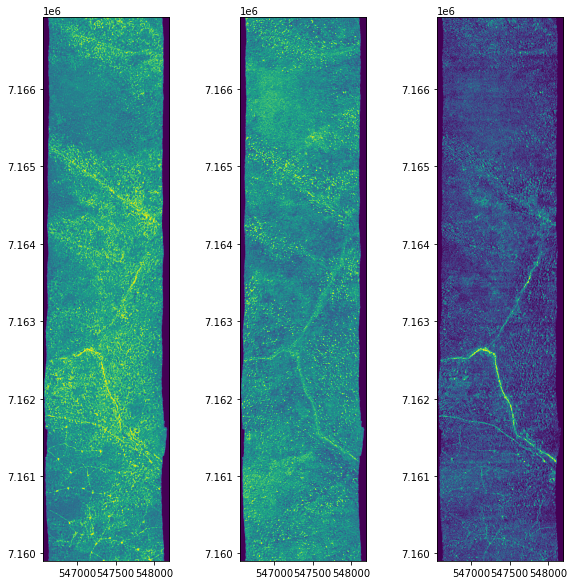

In [17]:
# Visualise PCA 1
img_pca1_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    pca_img, bands=[1],
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_pca1_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_pca1_data, no_data_val=-1.0)

# Visualise PCA 2
img_pca2_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    pca_img, bands=[2],
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_pca2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_pca2_data, no_data_val=-1.0)

# Visualise PCA 3
img_pca3_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    pca_img, bands=[3],
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_pca3_data_strch = rsgislib.tools.plotting.cumulative_stretch_np_arr(img_pca3_data, no_data_val=-1.0)

# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_pca1_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_pca2_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax3.imshow(img_pca3_data_strch, extent=img_coords)

Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


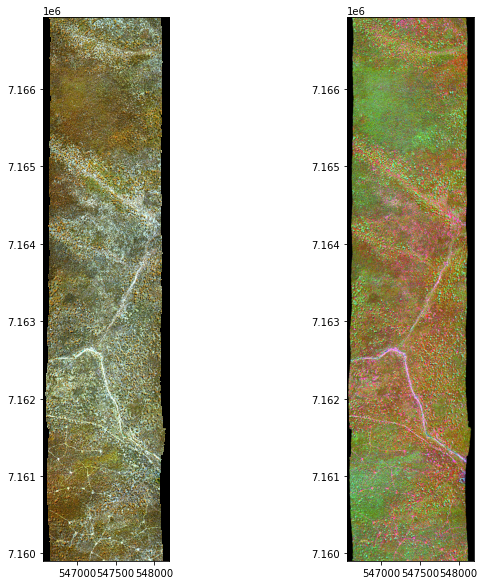

In [18]:
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[32, 19, 1]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Visualise principle components 1,2,3
img_pca_data, img_pca_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    pca_img, bands=[1, 2, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_pca_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_pca_data, no_data_val=-1.0)

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_pca_data_strch, extent=img_pca_coords)

# 10.2 Minimum Noise Fraction (MNF)

The MNF transformation is based on PCA but first uses the noise covariance matrix to decorrelate and rescale the noise in the data (noise whitening) before applying the PCA. This has been demonstrated to produce better results with less noise than PCA. 


In [19]:
mnf_img = os.path.join(out_dir, 'hymap_injune_subset_mnf.kea')

tmp_mnf_dir = "mnf_tmp"
if not os.path.exists(tmp_mnf_dir):
    os.mkdir(tmp_mnf_dir)

# As we know from the PCA we only need 5 components.
rsgislib.imagecalc.perform_image_mnf(input_img, mnf_img, n_comps=5, pxl_n_sample=100, in_img_no_data=0, tmp_dir=tmp_mnf_dir, gdalformat='KEA', datatype=rsgislib.TYPE_16INT, calc_stats=True)

0) hymap_injune_subset.kea
New image width = 628 height = 2702 bands = 1

Importing Bands:


100%|███████████████████████████████████████████████████████████████████████████████████████████| 126/126 [00:02<00:00, 56.36it/s]


Create empty output image file

Output Bands:


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:04<00:00, 11.59it/s]


15396 values were extracted from the input image.
Prop. of variance explained:
	 PCA Component 1 = 0.8219
	 PCA Component 2 = 0.1542
	 PCA Component 3 = 0.0119
	 PCA Component 4 = 0.0071
	 PCA Component 5 = 0.0023
	 PCA Component 6 = 0.0006
	 PCA Component 7 = 0.0005
	 PCA Component 8 = 0.0003
	 PCA Component 9 = 0.0002
	 PCA Component 10 = 0.0002
	 PCA Component 11 = 1e-04
	 PCA Component 12 = 1e-04
	 PCA Component 13 = 1e-04
	 PCA Component 14 = 1e-04
	 PCA Component 15 = 0.0
	 PCA Component 16 = 0.0
	 PCA Component 17 = 0.0
	 PCA Component 18 = 0.0
	 PCA Component 19 = 0.0
	 PCA Component 20 = 0.0
	 PCA Component 21 = 0.0
	 PCA Component 22 = 0.0
	 PCA Component 23 = 0.0
	 PCA Component 24 = 0.0
	 PCA Component 25 = 0.0
	 PCA Component 26 = 0.0
	 PCA Component 27 = 0.0
	 PCA Component 28 = 0.0
	 PCA Component 29 = 0.0
	 PCA Component 30 = 0.0
	 PCA Component 31 = 0.0
	 PCA Component 32 = 0.0
	 PCA Component 33 = 0.0
	 PCA Component 34 = 0.0
	 PCA Component 35 = 0.0
	 PCA Component 3

array([8.21926773e-01, 1.54240981e-01, 1.19294003e-02, 7.07589090e-03,
       2.25237873e-03, 6.30006718e-04, 4.67706093e-04, 3.18393024e-04,
       2.46637355e-04, 1.75432462e-04, 1.16807489e-04, 1.06229636e-04,
       7.64080251e-05, 6.46929693e-05, 4.16543626e-05, 3.59124897e-05,
       3.26109839e-05, 2.76270966e-05, 2.43050818e-05, 1.88117647e-05,
       1.66578193e-05, 1.57745744e-05, 1.36048711e-05, 1.24008220e-05,
       1.16891824e-05, 8.93120068e-06, 8.45995692e-06, 7.24982465e-06,
       6.45349610e-06, 6.08537175e-06, 5.10133441e-06, 4.36444816e-06,
       4.21443337e-06, 3.81553809e-06, 3.65215874e-06, 3.34582114e-06,
       3.03674005e-06, 2.76468836e-06, 2.59663352e-06, 2.43012846e-06,
       2.37700760e-06, 2.33197329e-06, 2.01903094e-06, 1.87669980e-06,
       1.78894072e-06, 1.69149121e-06, 1.59860099e-06, 1.55118801e-06,
       1.47557057e-06, 1.43467162e-06, 1.38108874e-06, 1.33318713e-06,
       1.29973307e-06, 1.20277218e-06, 1.16210913e-06, 1.13337126e-06,
      

In the outputs you will see the amount of variance described by each principal component, from which you can see that 82% is described by the first PC, 15% by the second PC with 1.0% by the third PC. *Note you're values might differ slightly.*

Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


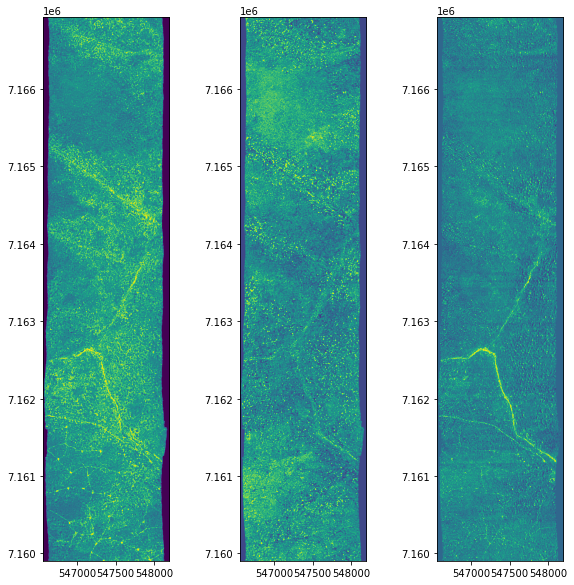

In [20]:
# Visualise MNF 1
img_mnf1_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    mnf_img, bands=[1],
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_mnf1_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_mnf1_data, no_data_val=None)

# Visualise MNF 2
img_mnf2_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    mnf_img, bands=[2],
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_mnf2_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_mnf2_data, no_data_val=None)

# Visualise MNF 3
img_mnf3_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    mnf_img, bands=[3],
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_mnf3_data_strch = rsgislib.tools.plotting.cumulative_stretch_np_arr(img_mnf3_data, no_data_val=None)

# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_mnf1_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_mnf2_data_strch, extent=img_coords)

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax3.imshow(img_mnf3_data_strch, extent=img_coords)

Image Data Size: 628 x 2702
Image Data Size: 628 x 2702
Image Data Size: 628 x 2702


Text(0.5, 1.0, 'MNF')

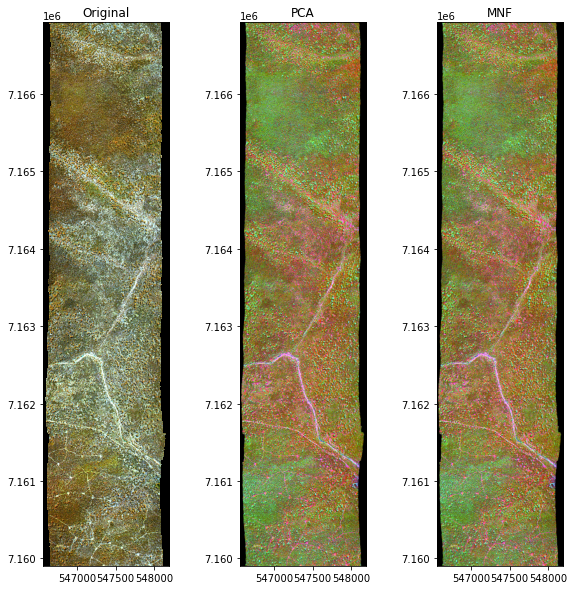

In [21]:
# Visualise with bands 32 (NIR), 19 (Red Edge) and 1 (Blue)
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[32, 19, 1]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)


# Visualise principle components 1,2,3
img_pca_data, img_pca_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    pca_img, bands=[1, 2, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_pca_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_pca_data, no_data_val=-1.0)

# Visualise principle components 1,2,3
img_mnf_data, img_mnf_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    pca_img, bands=[1, 2, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_mnf_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_mnf_data, no_data_val=-1.0)


# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax1.imshow(img_data_strch, extent=img_coords)
ax1.set_title("Original")

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax2.imshow(img_pca_data_strch, extent=img_pca_coords)
ax2.set_title("PCA")

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax3.imshow(img_mnf_data_strch, extent=img_mnf_coords)
ax3.set_title("MNF")